# 06_decision_support — Risk & Recommendations
Use **GP forecasts (mean±std)** + **hydrology & text flags** to compute daily **risk scores** and **operational recommendations**.

**Inputs**
- `master_with_topics.csv` (features + text)
- `predictions_test.csv` (from 05_modeling: `date, y_true, gpr_mean, gpr_std, ...`)

**Outputs**
- `decision_recommendations.csv` (date, risks, decision, rationale)

### Cell 1 — Imports & configuration

In [1]:
import pandas as pd, numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from scipy.stats import norm

plt.rcParams['figure.figsize'] = (11,4)

FEATURES_PATH = "master_with_topics.csv"
PRED_PATH     = "predictions_test.csv"   # produced by 05_modeling
OUT_PATH      = "decision_recommendations.csv"

# If plant capacity unknown, approximate from history (95th pct of load)
CAP_FALLBACK_PCT = 0.95
MIN_FALLBACK_PCT = 0.10

# Risk thresholds (tune)
THR_HIGH  = 0.60
THR_MED   = 0.35

print(Path(FEATURES_PATH).resolve())
print(Path(PRED_PATH).resolve())

C:\Users\abhis\Desktop\Big Data\Hydropower decision support system\master_with_topics.csv
C:\Users\abhis\Desktop\Big Data\Hydropower decision support system\predictions_test.csv


### Cell 2 — Load data & join forecasts

In [2]:
df = pd.read_csv(FEATURES_PATH, parse_dates=['date']).sort_values('date')
pred = pd.read_csv(PRED_PATH, parse_dates=['date']) if Path(PRED_PATH).exists() else None

# Detect load column
def first_existing(cols):
    for c in cols:
        if c in df.columns: return c
    return None

COL_LOAD = first_existing(['load_MW','peak_load_mw','avg_load_mw'])
COL_RAIN = first_existing(['rainfall_mm'])
COL_Q    = first_existing(['discharge_m3s','discharge_cms'])
COL_RES  = first_existing(['reservoir_m','gauge_m'])

print("Detected → load:", COL_LOAD, "| rain:", COL_RAIN, "| discharge:", COL_Q, "| reservoir:", COL_RES)

if pred is not None and {'date','gpr_mean','gpr_std'}.issubset(pred.columns):
    joined = df.merge(pred[['date','gpr_mean','gpr_std']], on='date', how='left')
else:
    # Fallback forecast (simple 7‑day moving average + residual std)
    tmp = df[['date', COL_LOAD]].set_index('date').sort_index().asfreq('D')
    gpr_mean = tmp[COL_LOAD].rolling(7, min_periods=3).mean()
    gpr_std  = (tmp[COL_LOAD] - gpr_mean).rolling(30, min_periods=7).std().fillna(gpr_mean.std())
    fallback = pd.DataFrame({'date': gpr_mean.index, 'gpr_mean': gpr_mean.values, 'gpr_std': gpr_std.values})
    joined = df.merge(fallback, on='date', how='left')

joined = joined.sort_values('date').reset_index(drop=True)
joined.head()

Detected → load: load_MW | rain: rainfall_mm | discharge: discharge_m3s | reservoir: reservoir_m


,date,discharge_m3s,reservoir_m,rainfall_mm,load_MW,avg_load_mw,energy_mwh,year,doy,dow,...,flood_flag,policy_flag,weather_flag,topic0,topic1,topic2,topic3,topic4,gpr_mean,gpr_std
0,2019-01-31,120.0,0.64,0.0,1428.760,946.092065,28941.248,2019.0,31,3,...,0.0,0.0,0.0,0.071865,0.13978,0.341538,0.28139,0.165426,NaN,NaN
1,2019-02-01,132.0,0.72,0.0,1437.155,970.446968,29686.272,2019.0,32,4,...,0.0,0.0,0.0,0.071865,0.13978,0.341538,0.28139,0.165426,NaN,NaN
2,2019-02-02,131.0,0.71,0.0,1395.755,967.499629,29596.112,2019.0,33,5,...,0.0,0.0,0.0,0.071865,0.13978,0.341538,0.28139,0.165426,NaN,NaN
3,2019-02-03,131.0,0.71,0.0,1352.055,926.954500,28355.824,2019.0,34,6,...,0.0,0.0,0.0,0.071865,0.13978,0.341538,0.28139,0.165426,NaN,NaN
4,2019-02-04,134.0,0.73,0.0,1373.905,918.874032,28108.640,2019.0,35,0,...,0.0,0.0,0.0,0.071865,0.13978,0.341538,0.28139,0.165426,NaN,NaN


### Cell 3 — Capacity/minimum & seasonal z‑scores

In [3]:
# Capacity/min thresholds
cap_mw = joined[COL_LOAD].quantile(CAP_FALLBACK_PCT) if COL_LOAD else joined['gpr_mean'].quantile(CAP_FALLBACK_PCT)
min_mw = joined[COL_LOAD].quantile(MIN_FALLBACK_PCT) if COL_LOAD else joined['gpr_mean'].quantile(MIN_FALLBACK_PCT)
print(f'Capacity≈P{int(CAP_FALLBACK_PCT*100)} = {cap_mw:.1f} MW | Minimum≈P{int(MIN_FALLBACK_PCT*100)} = {min_mw:.1f} MW')

# Seasonal (monthly) z‑scores for rain/discharge/reservoir
def monthly_z(x):
    return (x - x.groupby(joined['date'].dt.month).transform('mean')) /            (x.groupby(joined['date'].dt.month).transform('std').replace(0,np.nan))

joined['z_rain'] = monthly_z(joined[COL_RAIN]) if COL_RAIN in joined else 0.0
joined['z_q']    = monthly_z(joined[COL_Q])   if COL_Q in joined else 0.0
joined['z_res']  = monthly_z(joined[COL_RES]) if COL_RES in joined else 0.0

# Keyword flags
flags = [c for c in joined.columns if c.endswith('_flag')]
print("Flags:", flags[:10], "...")

Capacity≈P95 = 1775.7 MW | Minimum≈P10 = 1367.3 MW
Flags: ['maintenance_flag', 'outage_flag', 'flood_flag', 'policy_flag', 'weather_flag'] ...


### Cell 4 — Compute risk components

In [4]:
def sigmoid(x): return 1/(1+np.exp(-x))

# 1) Hydrology-driven spill risk
hydro_score = 0.5*sigmoid(joined['z_rain'].fillna(0)) + 0.5*sigmoid(joined['z_q'].fillna(0))
kw_spill = 0.7*joined.get('flood_flag', 0) + 0.3*joined.get('weather_flag', 0)
risk_spill = 1 - (1 - np.clip(hydro_score,0,1))*(1 - np.clip(kw_spill,0,1))

# 2) High-load risk from forecast (probability exceeding capacity)
z_hi = (cap_mw - joined['gpr_mean']) / joined['gpr_std'].replace(0, np.nan)
risk_highload = 1 - norm.cdf(z_hi.fillna(0))

# 3) Shortfall risk (probability below minimum)
z_lo = (joined['gpr_mean'] - min_mw) / joined['gpr_std'].replace(0, np.nan)
risk_shortfall = 1 - norm.cdf(z_lo.fillna(0))

# 4) Maintenance deferral risk
kw_maint = joined.get('maintenance_flag', 0) + joined.get('outage_flag', 0)
risk_maint_defer = 1 - (1 - np.clip(risk_spill,0,1))*(1 - np.clip(kw_maint,0,1))

risks = pd.DataFrame({
    'date': joined['date'],
    'risk_spill': np.clip(risk_spill,0,1),
    'risk_highload': np.clip(risk_highload,0,1),
    'risk_shortfall': np.clip(risk_shortfall,0,1),
    'risk_maint_defer': np.clip(risk_maint_defer,0,1),
})

### Cell 5 — Turn risks into recommendations

In [5]:
def level(p):
    return 'HIGH' if p>=THR_HIGH else ('MED' if p>=THR_MED else 'LOW')

decisions = []
for _, r in risks.iterrows():
    lv = {k: level(r[k]) for k in ['risk_spill','risk_highload','risk_shortfall','risk_maint_defer']}
    # Priority order
    if lv['risk_spill']=='HIGH':
        action = 'Spill advisory & downstream warning'
        why = 'High hydrology/flood signals; consider spill readiness and public alert.'
    elif lv['risk_maint_defer']=='HIGH':
        action = 'Defer maintenance; keep units available'
        why = 'High hydrology/outage context; risk to availability.'
    elif lv['risk_highload']=='HIGH':
        action = 'Prepare peak management (imports/demand response)'
        why = 'Forecasted load near capacity; plan imports/DR dispatch.'
    elif lv['risk_shortfall']=='HIGH':
        action = 'Plan load shedding window / optimize dispatch'
        why = 'Load forecast below minimum; risk of shortfall.'
    else:
        # Med priorities
        if lv['risk_spill']=='MED':
            action = 'Monitor inflows; pre-position spillway crew'
            why = 'Moderate spill risk; ensure readiness.'
        elif lv['risk_maint_defer']=='MED':
            action = 'Review maintenance schedule'
            why = 'Some risk; consider partial deferral.'
        elif lv['risk_highload']=='MED':
            action = 'Prepare peak hour support'
            why = 'Moderate high-load risk; line up support.'
        elif lv['risk_shortfall']=='MED':
            action = 'Monitor shortfall risk'
            why = 'Moderate shortfall; monitor closely.'
        else:
            action = 'Normal operations'
            why = 'All risks low.'
    decisions.append((r['date'], r['risk_spill'], r['risk_highload'], r['risk_shortfall'], r['risk_maint_defer'], action, why))

dec_df = pd.DataFrame(decisions, columns=['date','risk_spill','risk_highload','risk_shortfall','risk_maint_defer','decision','rationale'])
dec_df.head(10)

,date,risk_spill,risk_highload,risk_shortfall,risk_maint_defer,decision,rationale
0,2019-01-31,0.400503,0.5,0.5,0.400503,Monitor inflows; pre-position spillway crew,Moderate spill risk; ensure readiness.
1,2019-02-01,0.515009,0.5,0.5,0.515009,Monitor inflows; pre-position spillway crew,Moderate spill risk; ensure readiness.
2,2019-02-02,0.510859,0.5,0.5,0.510859,Monitor inflows; pre-position spillway crew,Moderate spill risk; ensure readiness.
3,2019-02-03,0.510859,0.5,0.5,0.510859,Monitor inflows; pre-position spillway crew,Moderate spill risk; ensure readiness.
4,2019-02-04,0.523239,0.5,0.5,0.523239,Monitor inflows; pre-position spillway crew,Moderate spill risk; ensure readiness.
5,2019-02-05,0.551087,0.5,0.5,0.551087,Monitor inflows; pre-position spillway crew,Moderate spill risk; ensure readiness.
6,2019-02-06,0.527314,0.5,0.5,0.527314,Monitor inflows; pre-position spillway crew,Moderate spill risk; ensure readiness.
7,2019-02-07,0.622472,0.5,0.5,0.622472,Spill advisory & downstream warning,High hydrology/flood signals; consider spill r...
8,2019-02-08,0.701427,0.5,0.5,0.701427,Spill advisory & downstream warning,High hydrology/flood signals; consider spill r...
9,2019-02-09,0.944388,0.5,0.5,0.944388,Spill advisory & downstream warning,High hydrology/flood signals; consider spill r...


### Cell 6 — Save and visualize

Saved: decision_recommendations.csv | rows: 1796


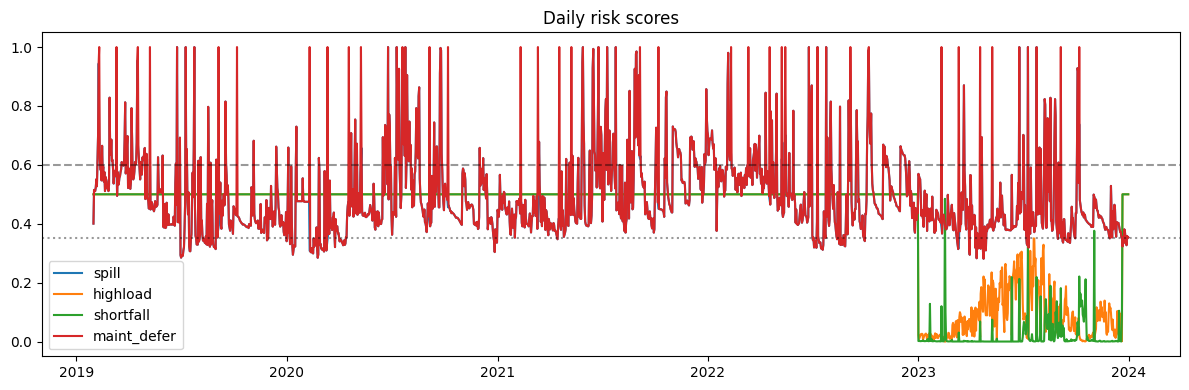

decision
Monitor inflows; pre-position spillway crew    1323
Spill advisory & downstream warning             309
Prepare peak hour support                       115
Normal operations                                29
Defer maintenance; keep units available          20
Name: count, dtype: int64

In [6]:
dec_df.to_csv(OUT_PATH, index=False)
print("Saved:", OUT_PATH, "| rows:", len(dec_df))

plt.figure(figsize=(12,4))
plt.plot(dec_df['date'], dec_df['risk_spill'], label='spill')
plt.plot(dec_df['date'], dec_df['risk_highload'], label='highload')
plt.plot(dec_df['date'], dec_df['risk_shortfall'], label='shortfall')
plt.plot(dec_df['date'], dec_df['risk_maint_defer'], label='maint_defer')
plt.axhline(THR_HIGH, color='k', linestyle='--', alpha=0.4)
plt.axhline(THR_MED,  color='k', linestyle=':', alpha=0.4)
plt.title('Daily risk scores')
plt.legend(); plt.tight_layout(); plt.show()

dec_df['decision'].value_counts()[:10]